#### Experiment: 

Evaluate pruning by magnitude weighted by coactivations (more thorough evaluation), compare it to baseline (SET).

#### Motivation.

Check if results are consistently above baseline.

#### Conclusion

- No significant difference between both models
- No support for early stopping

In [326]:
from IPython.display import Markdown, display
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [327]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *

import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

## Load and check data

In [328]:
base = os.path.join('gsc-dsnn-2019-10-11-G-reproduce')
exps = [
    os.path.join(base, exp) for exp in [
#         'gsc-Static', 
        'gsc-SET',
        'gsc-WeightedMag',
    ]
]
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

gsc-SET
gsc-WeightedMag


In [329]:
# replace hebbian prine
df['hebbian_prune_perc'] = df['hebbian_prune_perc'].replace(np.nan, 0.0, regex=True)
df['weight_prune_perc'] = df['weight_prune_perc'].replace(np.nan, 0.0, regex=True)
display(df.head(5)['hebbian_prune_perc'])
display(df.head(5)['weight_prune_perc'])

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: hebbian_prune_perc, dtype: float64

0    None-None-0.3-0.3
1    None-None-0.3-0.3
2    None-None-0.3-0.3
3    None-None-0.3-0.3
4    None-None-0.3-0.3
Name: weight_prune_perc, dtype: object

In [330]:
df.iloc[200:205]

,Experiment Name,train_acc_max,train_acc_max_epoch,train_acc_min,train_acc_min_epoch,train_acc_median,train_acc_last,val_acc_max,val_acc_max_epoch,val_acc_min,...,model,momentum,net_params,network,on_perc,optim_alg,prune_methods,test_noise,weight_decay,weight_prune_perc


In [331]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'val_acc_all',
       'epochs', 'experiment_file_name', 'experiment_base_path', 'trial_time',
       'mean_epoch_time', 'scatter_plot_dicts', 'batch_size_test',
       'batch_size_train', 'data_dir', 'dataset_name', 'debug_sparse',
       'debug_weights', 'device', 'hebbian_grow', 'hebbian_prune_perc',
       'learning_rate', 'lr_gamma', 'lr_milestones', 'lr_scheduler', 'model',
       'momentum', 'net_params', 'network', 'on_perc', 'optim_alg',
       'prune_methods', 'test_noise', 'weight_decay', 'weight_prune_perc'],
      dtype='object')

In [332]:
df.shape

(20, 43)

In [333]:
df.iloc[1]

Experiment Name              1_model=SET,on_perc=[0.04, 0.04, 0.04, 0.04]
train_acc_max                                                    0.852602
train_acc_max_epoch                                                    98
train_acc_min                                                    0.291378
train_acc_min_epoch                                                     0
train_acc_median                                                 0.825774
train_acc_last                                                   0.850991
val_acc_max                                                      0.914577
val_acc_max_epoch                                                      94
val_acc_min                                                      0.459639
val_acc_min_epoch                                                       0
val_acc_median                                                   0.882053
val_acc_last                                                     0.892633
val_acc_all             0     0.459639

In [334]:
df.groupby('model')['model'].count()

model
DSNNWeightedMag    10
SET                10
Name: model, dtype: int64

 ## Analysis

Experiment Details

In [335]:
# Did any  trials failed?
df[df["epochs"]<30]["epochs"].count()

0

In [336]:
# Removing failed or incomplete trials
df_origin = df.copy()
df = df_origin[df_origin["epochs"]>=30]
df.shape

(20, 43)

In [337]:
# which ones failed?
# failed, or still ongoing?
df_origin['failed'] = df_origin["epochs"]<30
df_origin[df_origin['failed']]['epochs']

Series([], Name: epochs, dtype: int64)

In [338]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


##### Does improved weight pruning outperforms regular SET

In [339]:
agg(['model'])

val_acc_max_epoch val_acc_max                      model
                       round_mean         min    max   mean    std count
model                                                                   
DSNNWeightedMag                83       0.841  0.924  0.883  0.037    10
SET                            88       0.841  0.922  0.886  0.035    10

In [340]:
agg(['on_perc'])

val_acc_max_epoch val_acc_max                      model
               round_mean         min    max   mean    std count
on_perc                                                         
0.02                   88       0.841  0.867  0.851  0.008    10
0.04                   83       0.908  0.924  0.918  0.004    10

In [341]:
def model_name(row):
    
    if row['model'] == 'DSNNWeightedMag':
        return 'DSNN'

    elif row['model'] == 'SET':
        return 'SET'

    elif row['model'] == 'SparseModel':
        return 'Static'
    
    assert False, "This should cover all cases. Got {} h - {} w - {}".format(row['model'], row['hebbian_prune_perc'], row['weight_prune_perc'])

df['model2'] = df.apply(model_name, axis=1) 

In [342]:
fltr = (df['model2'] != 'Sparse') & (df['lr_scheduler'] == "MultiStepLR")
agg(['on_perc', 'model2'], filter=fltr)

val_acc_max_epoch val_acc_max                      model
                      round_mean         min    max   mean    std count
on_perc model2                                                         
0.02    DSNN                  83       0.841  0.854  0.849  0.006     5
        SET                   93       0.841  0.867  0.853  0.009     5
0.04    DSNN                  83       0.908  0.924  0.918  0.006     5
        SET                   84       0.915  0.922  0.918  0.003     5

In [343]:
# translate model names
rcParams['figure.figsize'] = 16, 8
# d = {
#     'DSNNWeightedMag': 'DSNN',
#     'DSNNMixedHeb': 'SET',
#     'SparseModel': 'Static',        
# }
# df_plot = df.copy()
# df_plot['model'] = df_plot['model'].apply(lambda x, i: model_name(x, i))

<ErrorbarContainer object of 3 artists>

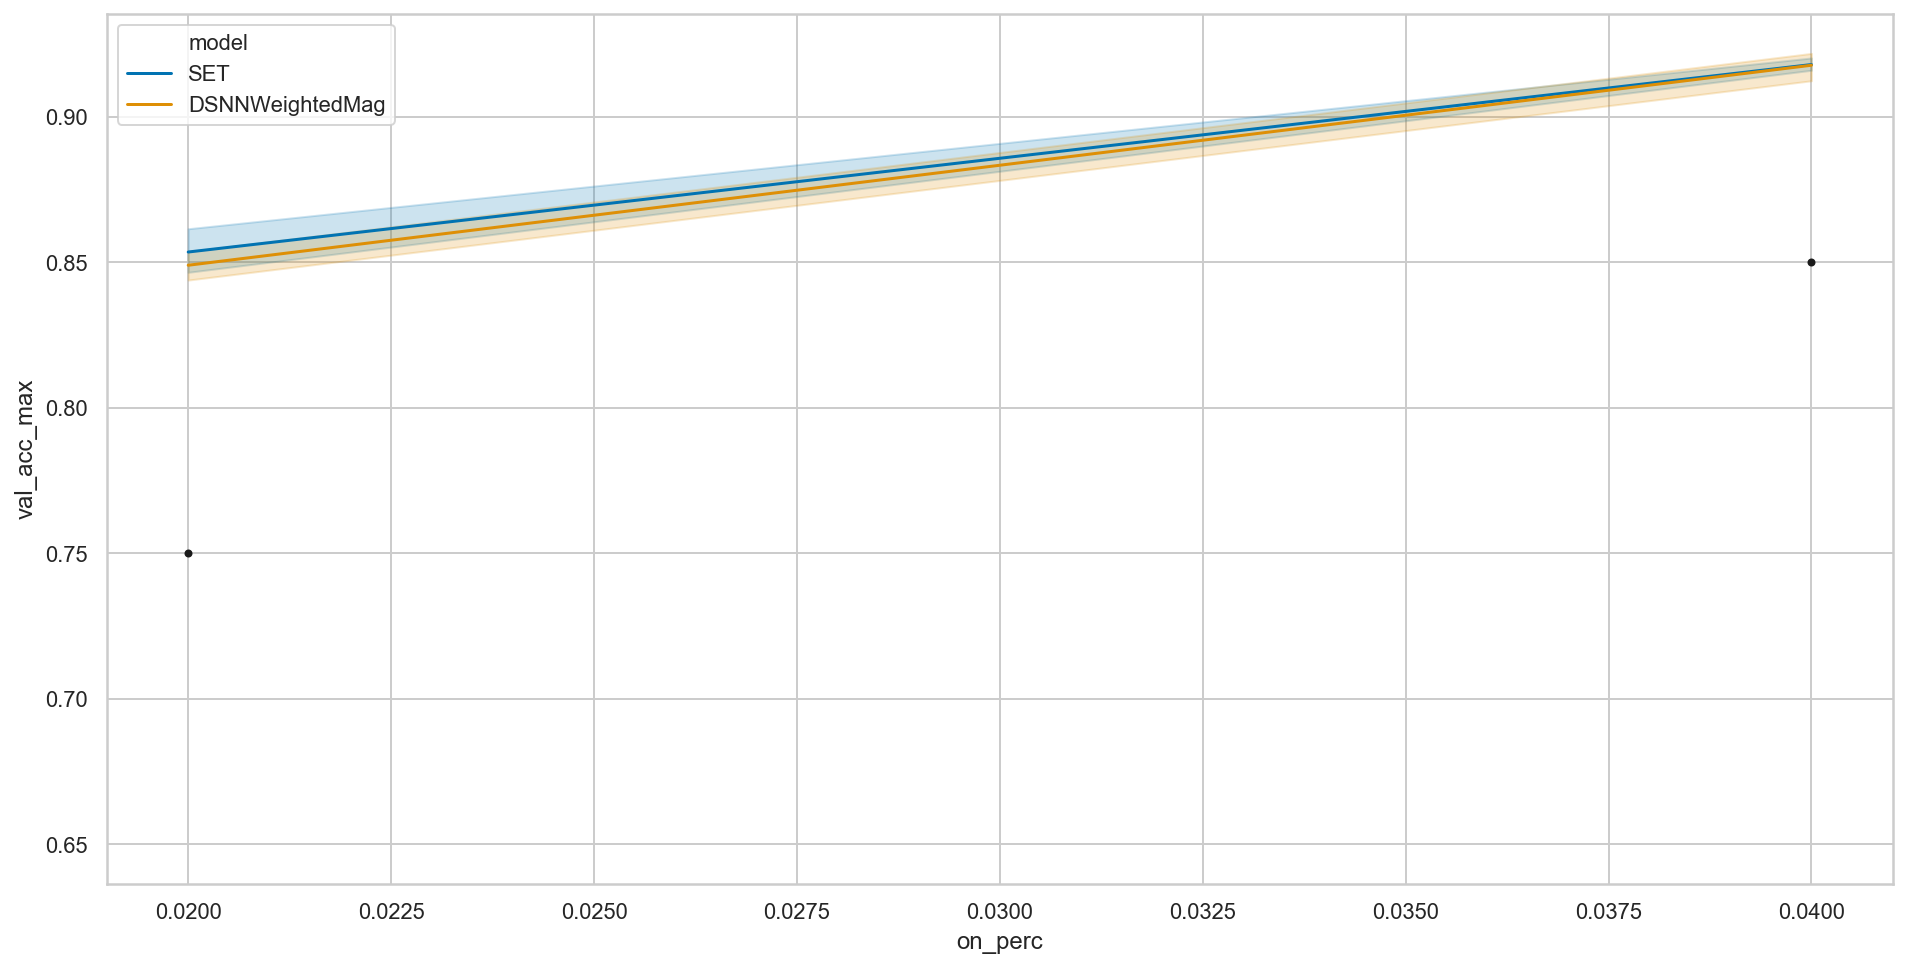

In [344]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df, x='on_perc', y='val_acc_max', hue='model')
plt.errorbar(x=[0.02, 0.04], y=[0.75, 0.85], yerr=[0.1, 0.01], color='k', marker='.', lw=0)

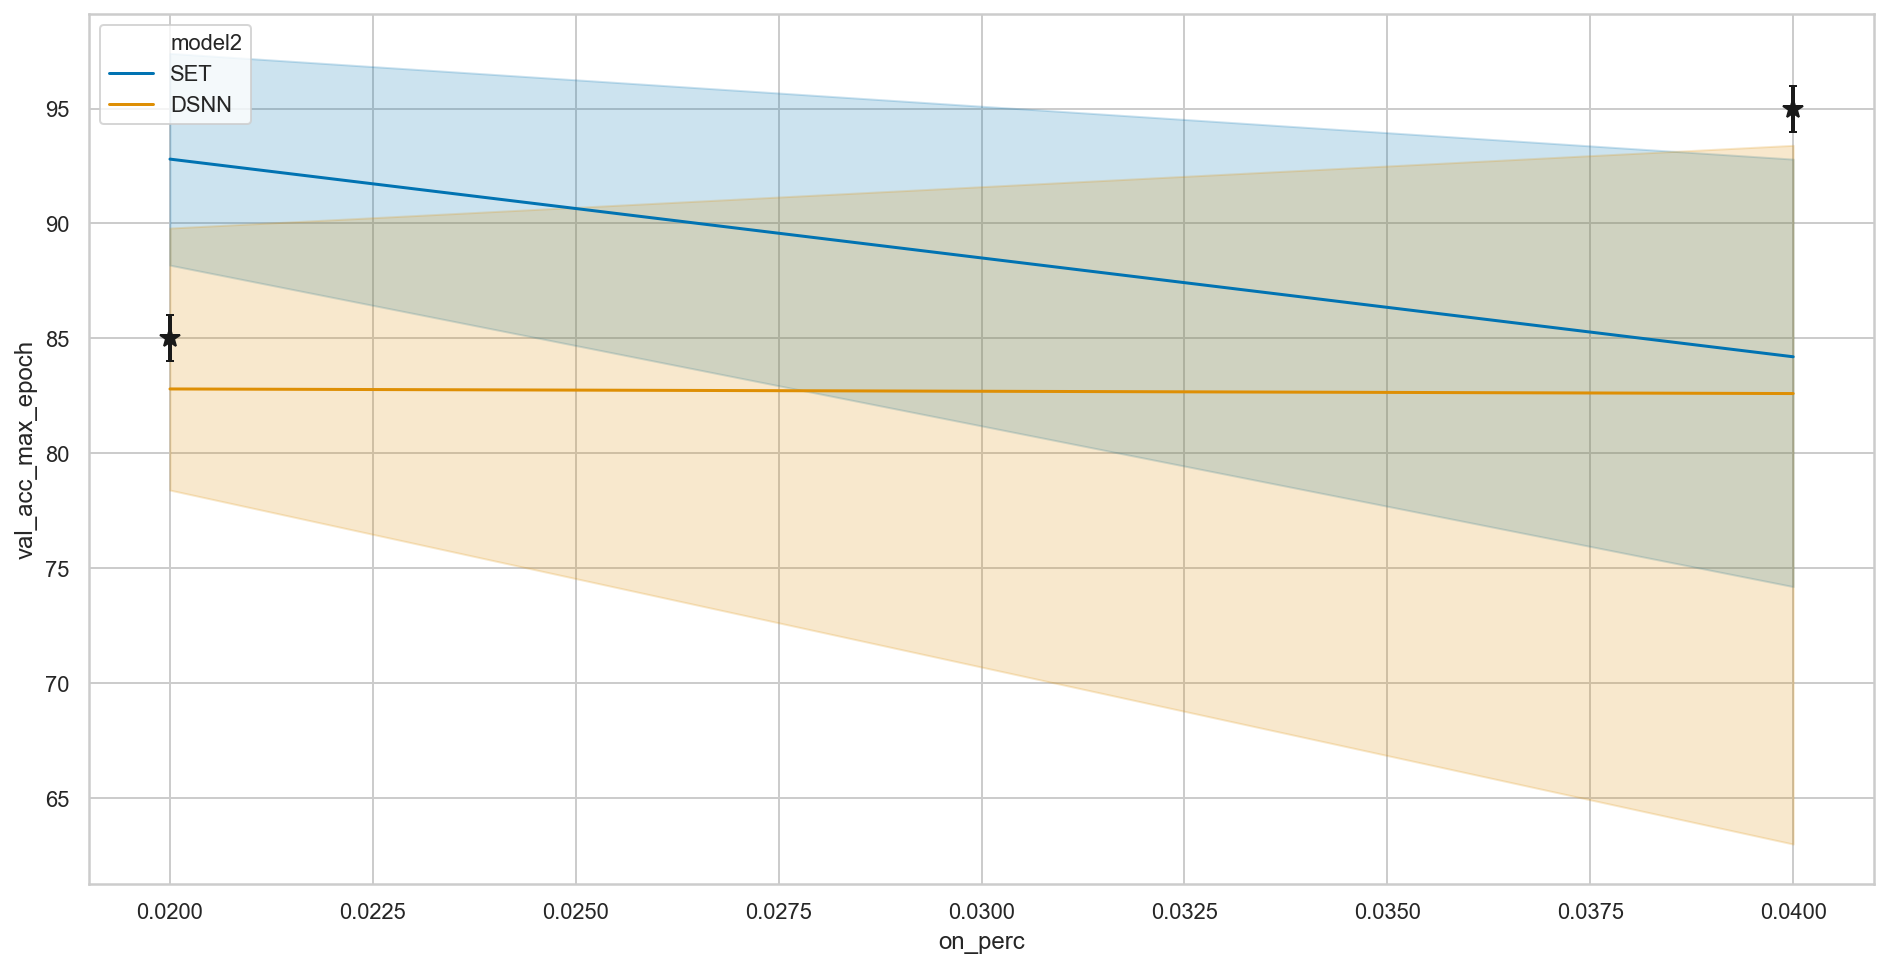

In [345]:
rcParams['figure.figsize'] = 16, 8
filter = df['model'] != 'Static'
plt.errorbar(
    x=[0.02, 0.04],
    y=[85, 95],
    yerr=[1, 1],
    color='k',
    marker='*',
    lw=0,
    elinewidth=2,
    capsize=2,
    markersize=10,
)
sns.lineplot(data=df[filter], x='on_perc', y='val_acc_max_epoch', hue='model2')

<ErrorbarContainer object of 3 artists>

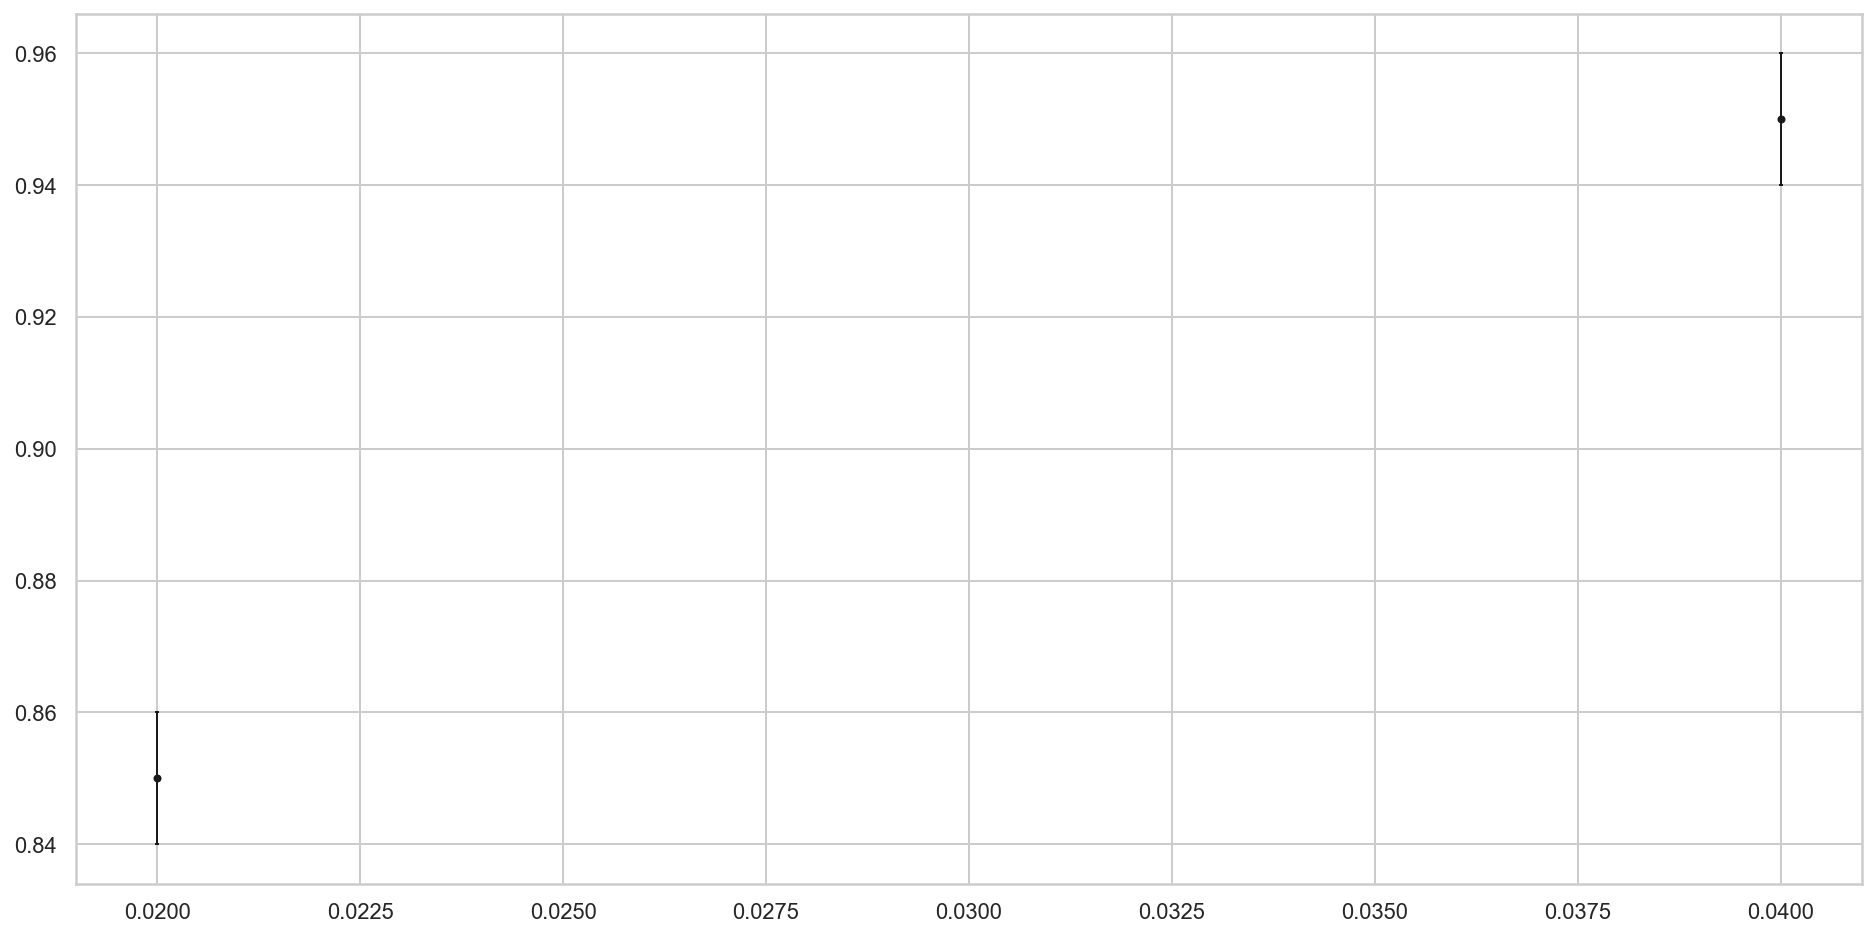

In [346]:
plt.errorbar(
    x=[0.02, 0.04],
    y=[0.85, 0.95],
    yerr=[0.01, 0.01],
    color='k',
    marker='.',
    lw=0,
    elinewidth=1,
    capsize=1,
)

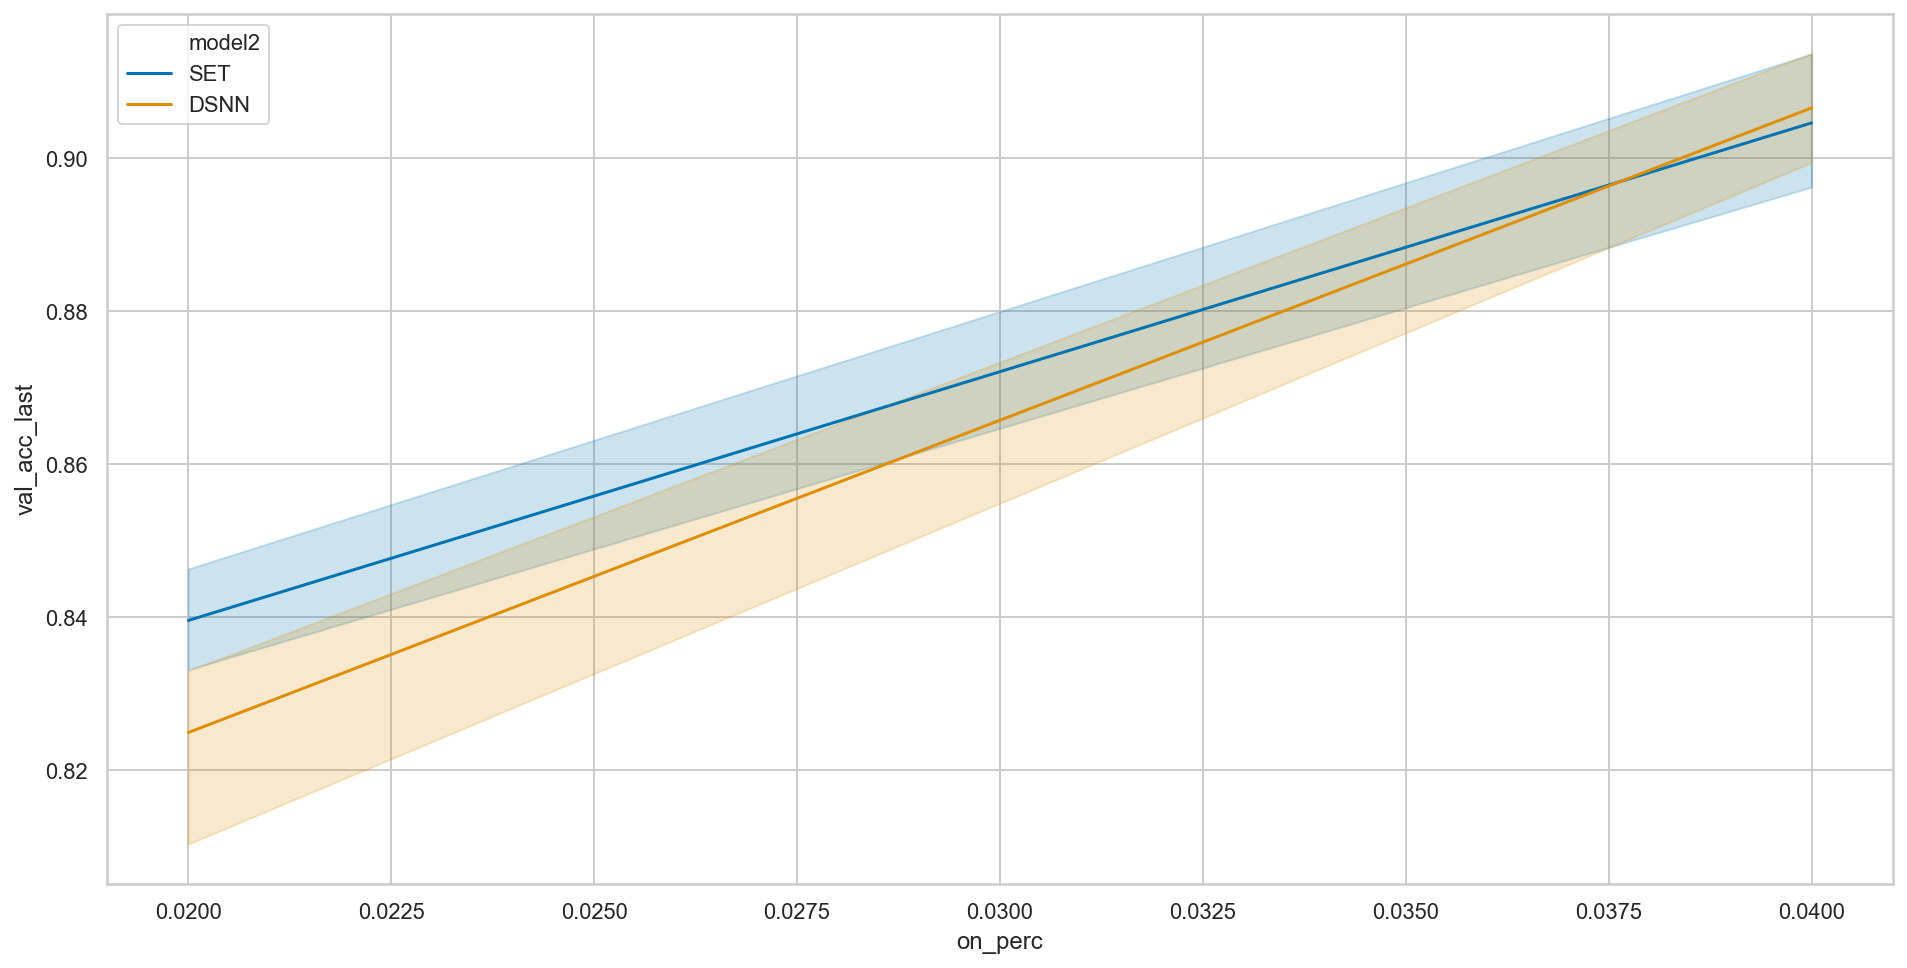

In [347]:
sns.lineplot(data=df, x='on_perc', y='val_acc_last', hue='model2')